# Evaluation task<a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-formatting" data-toc-modified-id="Imports-and-formatting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and formatting</a></span></li><li><span><a href="#Exploring-the-data" data-toc-modified-id="Exploring-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploring the data</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Data-overview" data-toc-modified-id="Data-overview-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Data overview</a></span></li><li><span><a href="#Missing-values" data-toc-modified-id="Missing-values-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Missing values</a></span></li><li><span><a href="#Correlations" data-toc-modified-id="Correlations-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>Correlations</a></span></li><li><span><a href="#Kernel-density-plots" data-toc-modified-id="Kernel-density-plots-2.0.4"><span class="toc-item-num">2.0.4&nbsp;&nbsp;</span>Kernel density plots</a></span></li><li><span><a href="#Class-distribution" data-toc-modified-id="Class-distribution-2.0.5"><span class="toc-item-num">2.0.5&nbsp;&nbsp;</span>Class distribution</a></span></li><li><span><a href="#Dimensionality-reduction" data-toc-modified-id="Dimensionality-reduction-2.0.6"><span class="toc-item-num">2.0.6&nbsp;&nbsp;</span>Dimensionality reduction</a></span><ul class="toc-item"><li><span><a href="#Key-takeaways-(PCA)" data-toc-modified-id="Key-takeaways-(PCA)-2.0.6.1"><span class="toc-item-num">2.0.6.1&nbsp;&nbsp;</span>Key takeaways (PCA)</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Logistic-regression-(2-dimensional-data)" data-toc-modified-id="Logistic-regression-(2-dimensional-data)-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Logistic regression (2-dimensional data)</a></span></li><li><span><a href="#Logistic-regression-(using-all-features)" data-toc-modified-id="Logistic-regression-(using-all-features)-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Logistic regression (using all features)</a></span></li><li><span><a href="#Learning-curves" data-toc-modified-id="Learning-curves-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>Learning curves</a></span></li></ul></li></ul></li></ul></div>

### Imports and formatting

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import shap

from collections import defaultdict
from statistics import mean
import time

In [2]:
# Load and format

cols = ["ID", "diagnosis"]
names_list = ["radius", "texture", "perimeter", "area", "smoothness", "compactness",
               "concavity", "concave_pts", "symmetry", "fractal_dim"]

cols_to_add = []
for i, name in enumerate(name for _ in range(3) for name in names_list):
    if i < 10:
        name = name + "_mean"
    if i >= 10 and i < 20:
        name = name + "_sd"
    if i >= 20:
        name = name + "_extr"
    cols_to_add.append(name)
    
cols.extend(cols_to_add)

data = pd.read_csv("wdbc.data", names=cols)
data.drop(["ID"], axis=1, inplace = True)

data_train = data.copy()
data_train.drop(["diagnosis"], axis=1, inplace=True)

y = data['diagnosis']
y = y.map({"M":1, "B": 0})

### Exploring the data

##### Data overview
Taking a look at the data. All numeric columns except for the target 'diagnosis' feature.

In [3]:
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_pts_mean,symmetry_mean,...,radius_extr,texture_extr,perimeter_extr,area_extr,smoothness_extr,compactness_extr,concavity_extr,concave_pts_extr,symmetry_extr,fractal_dim_extr
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# <a class="tocSkip">

##### Missing values

Checking for missing and null values. None found.

In [4]:
data.isna().sum().sum()

0

In [5]:
data.isnull().sum().sum()

0

# <a class="tocSkip">

##### Correlations

Finding the most correlated features and the absolute degree of correlation between them.

In [6]:
corr_matrix = data.corr().abs()

corr_top_20 = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))[:20]

The top 20 correlated feature pairs are: 

In [7]:
corr_top_20

radius_mean     perimeter_mean      0.997855
radius_extr     perimeter_extr      0.993708
radius_mean     area_mean           0.987357
perimeter_mean  area_mean           0.986507
radius_extr     area_extr           0.984015
perimeter_extr  area_extr           0.977578
radius_sd       perimeter_sd        0.972794
perimeter_mean  perimeter_extr      0.970387
radius_mean     radius_extr         0.969539
perimeter_mean  radius_extr         0.969476
radius_mean     perimeter_extr      0.965137
area_mean       radius_extr         0.962746
                area_extr           0.959213
                perimeter_extr      0.959120
radius_sd       area_sd             0.951830
perimeter_mean  area_extr           0.941550
radius_mean     area_extr           0.941082
perimeter_sd    area_sd             0.937655
concavity_mean  concave_pts_mean    0.921391
texture_mean    texture_extr        0.912045
dtype: float64

A lot of the features are **highly** correlated. Some preprocessing must be done. We do this later.

# <a class="tocSkip">

##### Kernel density plots

Plotting kernel densities of the features against the response, to view their distributions.

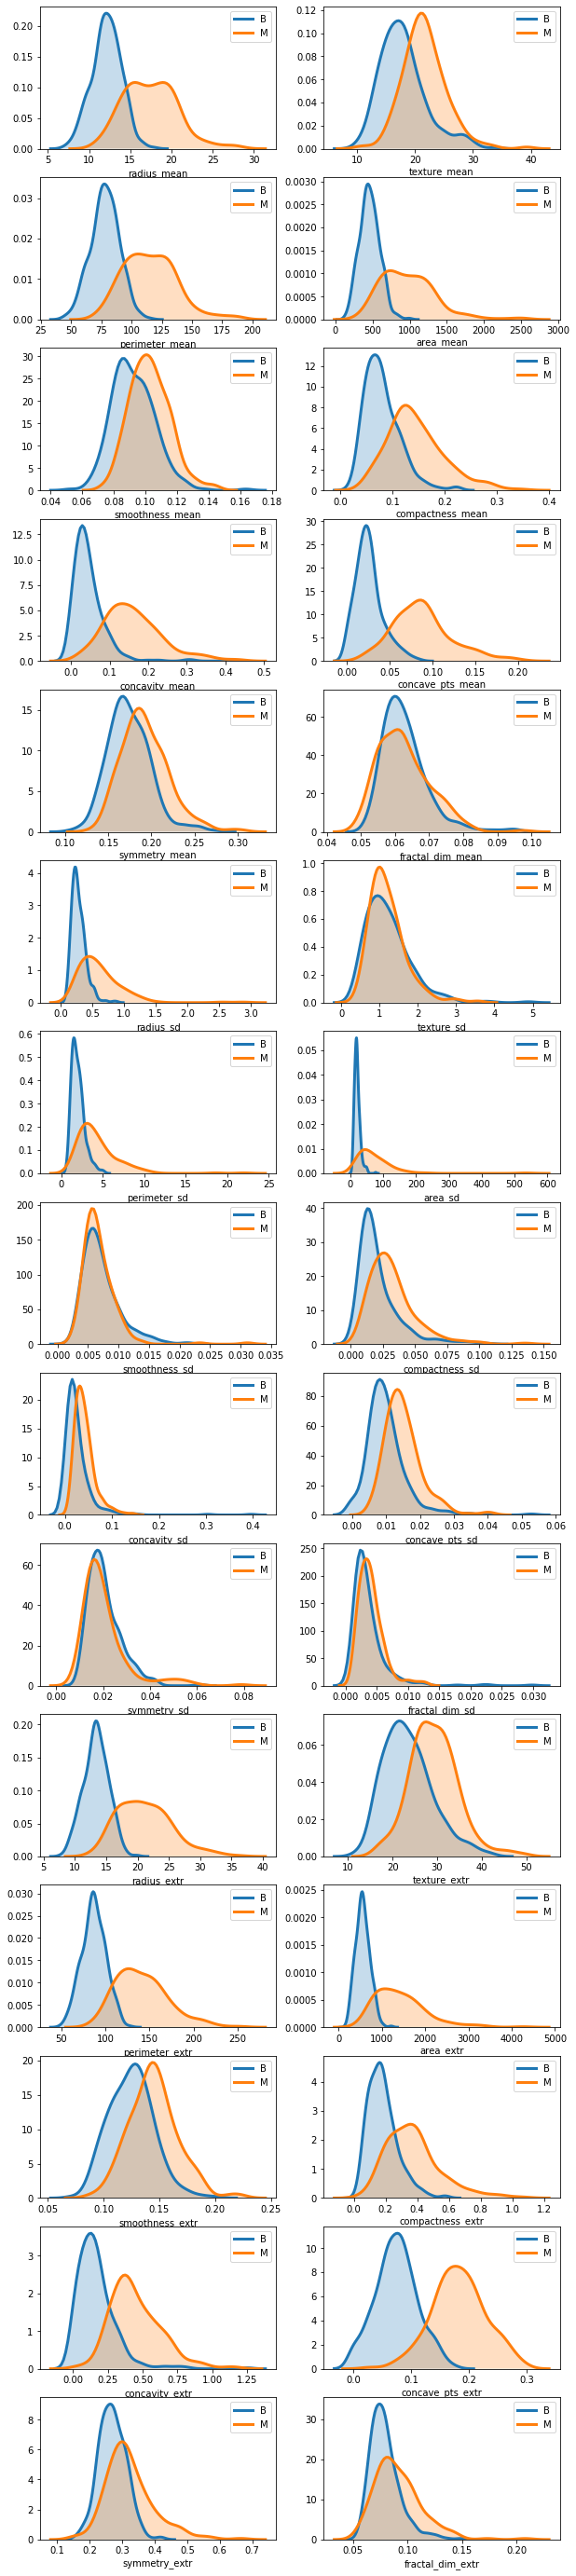

In [8]:
# KDE plot

fig, axes = plt.subplots(15, 2, figsize=(10, 50))

col_track = 0
for i in range(15):
    for j in range(2):
        for diag in ['B', 'M']:
            subset = data[data['diagnosis'] == diag]
            sns.distplot(subset[cols[col_track + 2]], hist = False, kde = True,
                         kde_kws = {'shade': True, 'linewidth': 3},
                         label = diag, ax=axes[i,j])
        col_track += 1


From these plots, we can see that the feature distributions for the 'M' (malignant) class are often more "spread out" than those of the 'B' (benign) class. Most of them have shorter peaks and fatter tails as a result. 

Keeping an open mind, this likely means that the 'M' and 'B' class observations are generated from two very different processes - so much so that the differences between them are readily apparent through visual means. 

# <a class="tocSkip">

##### Class distribution

The dataset is imbalanced in favour of the benign class, but not to a very high degree.

In [9]:
data['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

# <a class="tocSkip">

##### Dimensionality reduction
It might help to investigate the data by reducing it to a lower feature space. This will also help us mitigate the high feature correlations we saw earlier.

Here, we reduce the dimensionality of the data from 30 to 2 dimensions using Principal Component Analysis (PCA).

Standardising features before PCA, important to remove discrepancies in feature variances.

In [10]:
# Standardisation

std_scaler = StandardScaler(copy=True)
std_scaler.fit(data_train)

data_std = pd.DataFrame(std_scaler.transform(data_train), columns=cols[2:])


Total percentage of variance explained by the 2 PCs: 0.6324320765155943


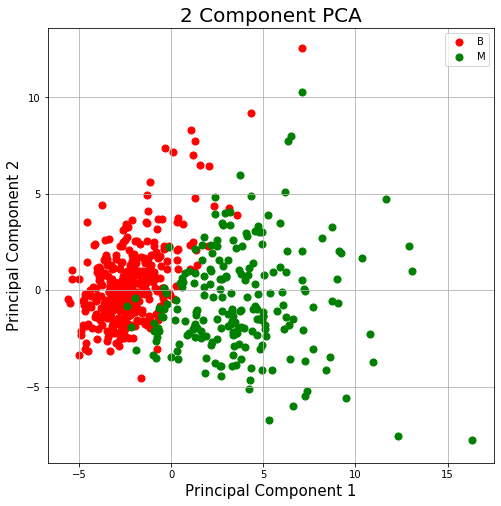

In [11]:
# PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_std)

data_pca = pd.DataFrame(data = data_pca, columns=["pc_1", "pc_2"])

pca_df = pd.concat([data_pca, data['diagnosis']], axis=1)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['B','M']
colours = ['r', 'g']
for target, color in zip(targets, colours):
    indicesToKeep = pca_df['diagnosis'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'pc_1']
               , pca_df.loc[indicesToKeep, 'pc_2'], c = color, s = 50)
ax.legend(targets)
ax.grid()

print("\nTotal percentage of variance explained by the 2 PCs: {}".format(pca.explained_variance_ratio_.sum()))

###### Key takeaways (PCA)  

In two dimensional space, the decision boundary between the two classes appears to be (approximately) **linearly separable**, although there is some overlap in the observations. 

The observations of the malignant class are also more spread out (higher variance), mirroring what was seen in the KDE plots from section 2.4. 

Another advantage of performing PCA is that the **resulting principal components are uncorrelated**. We thus solve the problem of highly correlated features. 

Just to be sure of this assertion, we can perform a sanity check.

In [12]:
data_pca.corr().abs()

,pc_1,pc_2
pc_1,1.000000e+00,4.964208e-17
pc_2,4.964208e-17,1.000000e+00


The correlations are practically zero in magnitude.   

We will try to fit a linear model into this new 2-dimensional representation and see how it performs. 

# <a class="tocSkip">

### Classification

##### Logistic regression (2-dimensional data)

We now train a logistic regression classifier, because we suspect a linear classifier is suitable. 

For regularisation, we use the **L2 (Ridge) penalty** and the class imbalance is addressed by giving more weight to the under-represented class.

We use **Stratified k-fold** cross-validation to ensure that the folds are representative of the total class distribution. 

The same 2-dimensional PCA dataset is used, since we saw a potential linear decision boundary there. 

In [13]:
# Log-Reg 2D

log_reg = LogisticRegression(fit_intercept=True, class_weight='balanced', 
            penalty='l2', solver='liblinear')

skf = StratifiedKFold(n_splits=10)

metrics_2d = defaultdict(list)
progress_print = False

start = time.time()
for train_index, val_index in skf.split(data_pca, y):
    X_train, y_train = data_pca.iloc[train_index], y.iloc[train_index]
    X_val, y_val = data_pca.iloc[val_index], y.iloc[val_index]
    log_reg.fit(X_train, y_train)

    preds = log_reg.predict(X_val)
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_val, preds, average='binary')
    accuracy = accuracy_score(y_val, preds)
    conf_mat = confusion_matrix(y_val, preds)
    
    metrics_2d['precision'].append(precision)
    metrics_2d['recall'].append(recall)
    metrics_2d['fscore'].append(fscore)
    metrics_2d['accuracy'].append(accuracy)
    metrics_2d['conf_mat'].append(conf_mat)
    
    if progress_print:
        print("Precision: {}\nRecall: {}\nF-Score: {}\nAccuracy: {}\n\nConfusion matrix: {}\n\n".format(
        precision, recall, fscore, accuracy, conf_mat), "*"*50)

end = time.time()

print("\nMean F1 score: {}\nMean accuracy: {}".format(mean(metrics_2d['fscore']), 
                                                      mean(metrics_2d['accuracy'])))

print("\nTime taken to execute: {} seconds".format(round(end-start, 2)))


Mean F1 score: 0.9330630867840171
Mean accuracy: 0.9490601503759398

Time taken to execute: 0.07 seconds


Even with 2 dimensions and a relatively small number of observations in the dataset, we see mean F1 score and accuracy to be above 90%. 

It appears the linear separability of the data helped give good results with the linear classifier. 

# <a class="tocSkip">

##### Logistic regression (using all features)

For comparison, we now train the same Log-Reg model using all 30 original features. 

However, we use the **L1 (lasso) penalty** here due to its inherent feature selection capability. 

In [14]:
# Log-Reg all features

log_reg = LogisticRegression(fit_intercept=True, class_weight='balanced', 
            penalty='l1', solver='liblinear')

skf = StratifiedKFold(n_splits=10)

metrics_full = defaultdict(list)
progress_print = False

start = time.time()
for train_index, val_index in skf.split(data_std, y):
    X_train, y_train = data_std.iloc[train_index], y.iloc[train_index]
    X_val, y_val = data_std.iloc[val_index], y.iloc[val_index]
    log_reg.fit(X_train, y_train)

    preds = log_reg.predict(X_val)
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_val, preds, average='binary')
    accuracy = accuracy_score(y_val, preds)
    conf_mat = confusion_matrix(y_val, preds)
    
    metrics_full['precision'].append(precision)
    metrics_full['recall'].append(recall)
    metrics_full['fscore'].append(fscore)
    metrics_full['accuracy'].append(accuracy)
    metrics_full['conf_mat'].append(conf_mat)
    
    if progress_print:
        print("Precision: {}\nRecall: {}\nF-Score: {}\nAccuracy: {}\n\nConfusion matrix: {}\n\n".format(
        precision, recall, fscore, accuracy, conf_mat), "*"*50)

end = time.time()

print("\nMean F1 score: {}\nMean accuracy: {}".format(mean(metrics_full['fscore']), 
                                                      mean(metrics_full['accuracy'])))

print("Time taken to execute: {} seconds".format(round(end-start, 2)))


Mean F1 score: 0.9693039543805284
Mean accuracy: 0.9771303258145363
Time taken to execute: 0.2 seconds


There is marginal improvement in the performance metrics with an almost doubled computation time. 

There seems to be diminishing returns for added complexity. 

###### Key takeaways (Regularisation)

Regularisation is often used to combat overfitting. 

It helps by artifically inflating the values of the model parameters by multiplying them with a regularisation parameter. This in turn inflates the loss function and forces the model to set lower values for the parameters during training. 

Lower parameter values are calcuated in the hope of achieving better model generalisation.

Regularisation comes in two types - 
L1 (lasso) - Here the absolute values of the paramters are penalised. This can drive some parameter values to zero, and thus, eliminate the corresponding features. It is more robust to outliers but generates a less stable solution.

L2 (ridge) - Here the squared values of the parameters are penalised. We keep all parameters. It is less robust to outliers but generates a more stable solution. 

# <a class="tocSkip">

##### Learning curves

We choose from several candidate models with the help of learning curves.

Here, we examine the performance of three different classifiers (Logistic Regression, Naive Bayes and Support Vector Machines).

The code below has been adapted from the scikit-learn example [here.](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)

In [15]:
# Learning curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples\n")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="lower right")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples\n")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

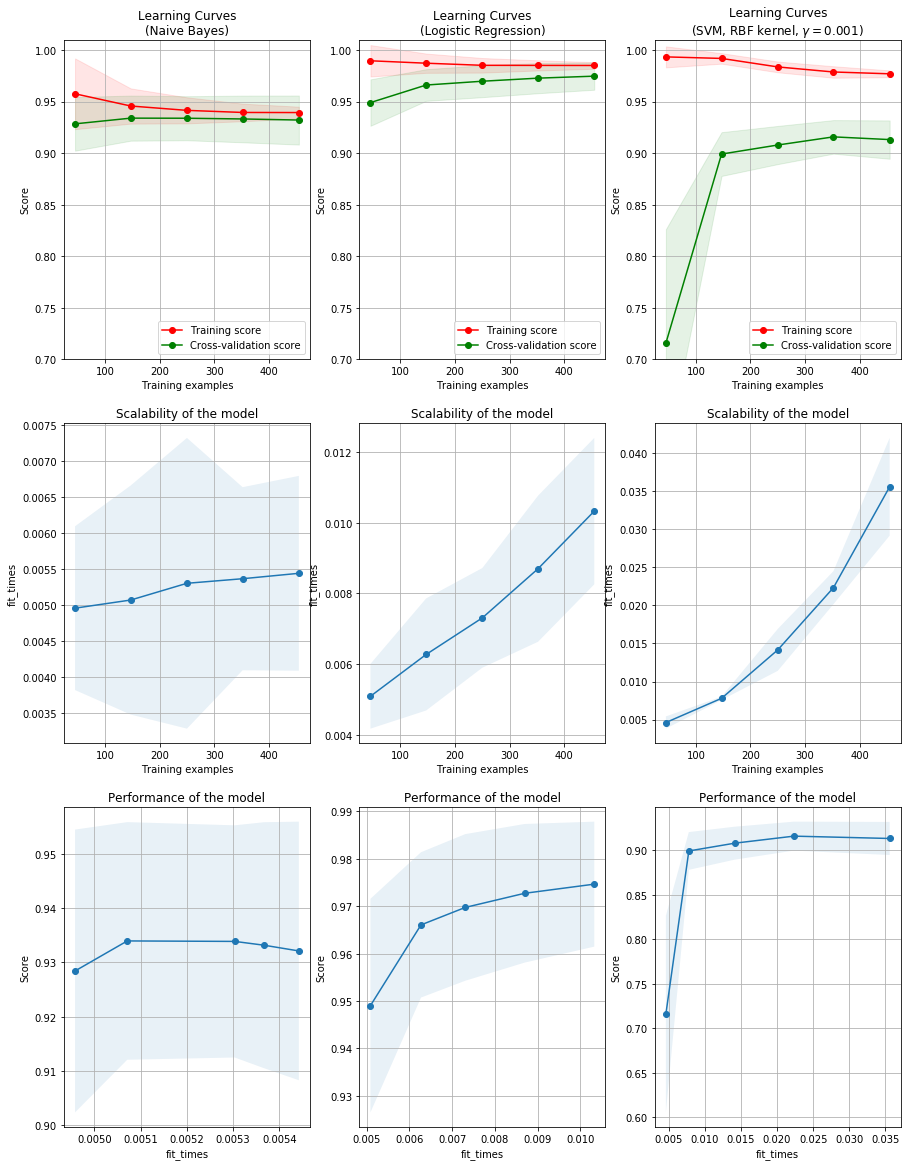

In [16]:
# Plotting

fig, axes = plt.subplots(3, 3, figsize=(15, 20))

title = "Learning Curves\n(Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, data_std, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves\n(Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegression(fit_intercept=True, class_weight='balanced', 
            penalty='l1', solver='liblinear')
plot_learning_curve(estimator, title, data_std, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves\n(SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, data_train, y, axes=axes[:, 2], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

From the top row of the plot: 

**Ideal scenario**: We expect the training score to start high and then be drawn slightly downwards as the model sees more examples. Consequently the validation score starts low and is then pulled upwards. The two should ideally converge at a high value. This is seen in both Naive Bayes and Logistic Regression. 

**Underfit**: When the training score and validation score are both on the lower side and are converging. This could be a characteristic of the model itself, and that augmenting with more training data or implementing regularisation is not likely to help.

**Overfit**: When the training score is high but the validation score doesn't catch up with it. We see this in the SVC classifier here. In this case, getting more training data and implementing regularisation might help.  
